
# Stock Price Data Analysis (Starter)

This notebook fetches daily prices via **yfinance**, computes **moving averages**, **daily returns**, **volatility**, and a **correlation matrix**, and creates clean visualizations.  
**Edit the config below** to set your tickers and date range.


In [1]:

# Imports
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Folders (created if missing)
os.makedirs("../data", exist_ok=True)
os.makedirs("../output/figures", exist_ok=True)
os.makedirs("../output/tables", exist_ok=True)

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
print("Libraries ready.")


Libraries ready.



## Configuration

- **TICKERS**: list of tickers (include `.L` suffix for LSE).  
- **DATE_START / DATE_END**: date range for downloads.  
- **SELECTED_TICKER**: which ticker to focus on in single-ticker plots.  


In [2]:

# --- Edit these ---
TICKERS = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
DATE_START = "2018-01-01"
DATE_END = None  # None = up to today
SELECTED_TICKER = "AAPL"
RISK_FREE_RATE = 0.00  # simple assumption for Sharpe
WINDOW_FAST = 20
WINDOW_SLOW = 50

print(f"Tickers: {TICKERS}")


Tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']



## Download & Cache Data
We download each ticker separately, **save a CSV** to `../data/`, and build a wide **Adj Close** table.


In [3]:
import os
import pandas as pd
import yfinance as yf

TICKERS = ["AAPL", "MSFT"]  # Replace with tickers you know exist
DATE_START = "2018-01-01"
DATE_END = None

price_dfs = []  # list to hold each ticker's DataFrame

for t in TICKERS:
    csv_path = f"../data/{t}_daily.csv"
    
    # Delete old CSV
    if os.path.exists(csv_path):
        os.remove(csv_path)
        print(f"Deleted old CSV: {csv_path}")
    
    # Download fresh data
    df = yf.download(t, start=DATE_START, end=DATE_END, auto_adjust=True)
    
    if df.empty:
        print(f"Warning: No data returned for {t}")
        continue
    
    df.reset_index(inplace=True)  # Ensure 'Date' is a column
    df.to_csv(csv_path, index=False)
    
    # Keep only 'Date' and 'Close', rename Close column to ticker symbol
    df = df[['Date', 'Close']].rename(columns={'Close': t})
    df.set_index('Date', inplace=True)
    
    price_dfs.append(df)

# Merge all tickers on Date
if price_dfs:
    prices_df = pd.concat(price_dfs, axis=1)
    print(prices_df.tail())
else:
    print("Error: No valid tickers downloaded.")


Deleted old CSV: ../data/AAPL_daily.csv


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Deleted old CSV: ../data/MSFT_daily.csv
Price          AAPL     MSFT
Ticker         AAPL     MSFT
Date                        
2025-09-02 229.7200 505.1200
2025-09-03 238.4700 505.3500
2025-09-04 239.7800 507.9700
2025-09-05 239.6900 495.0000
2025-09-08 239.2092 500.7150



## Exploratory Analysis: Normalized Prices
Normalize each series to **1.0 at the start** to compare relative performance.


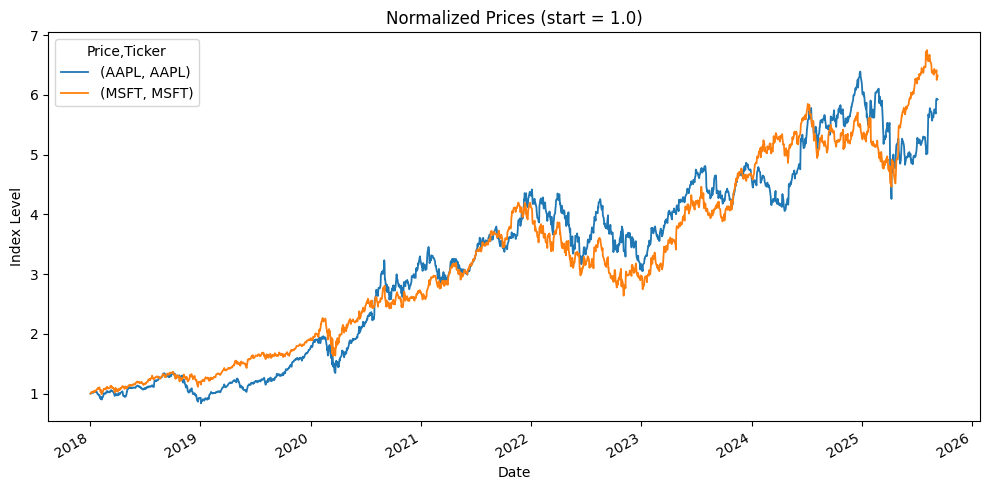

In [4]:
import matplotlib.pyplot as plt

# Normalized prices
norm = prices_df / prices_df.iloc[0]

plt.figure(figsize=(10, 5))
norm.plot(ax=plt.gca(), linewidth=1.3)
plt.title("Normalized Prices (start = 1.0)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.tight_layout()
plt.savefig("../output/figures/normalized_prices.png", dpi=150)
plt.show()



## Moving Averages & Single-Ticker View
Compute **SMA 20/50** and plot for `SELECTED_TICKER`.


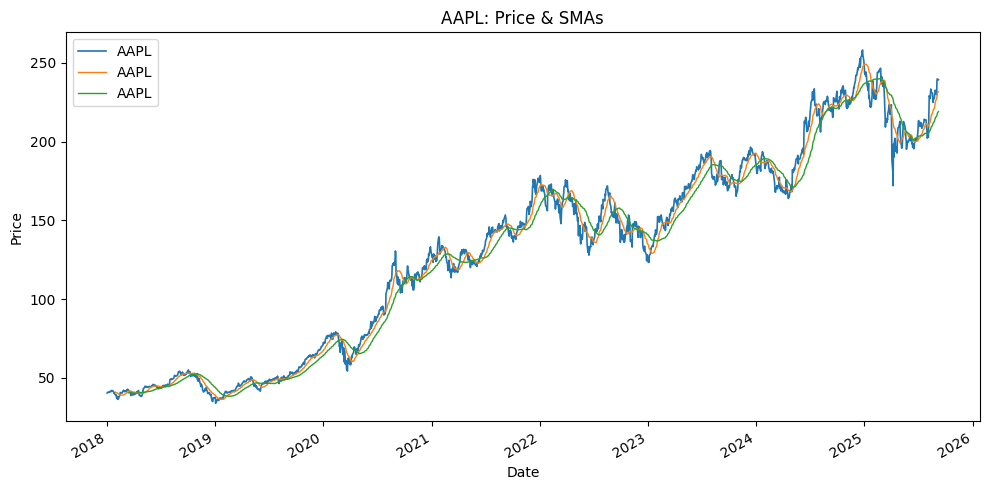

In [5]:
# Set parameters
WINDOW_FAST = 20
WINDOW_SLOW = 50
SELECTED_TICKER = "AAPL"  # choose a ticker from prices_df.columns

# Moving averages
ma_fast = prices_df.rolling(WINDOW_FAST).mean()
ma_slow = prices_df.rolling(WINDOW_SLOW).mean()

series = prices_df[SELECTED_TICKER].dropna()
sma_f = ma_fast[SELECTED_TICKER].dropna()
sma_s = ma_slow[SELECTED_TICKER].dropna()

plt.figure(figsize=(10, 5))
series.plot(ax=plt.gca(), label=SELECTED_TICKER, linewidth=1.2)
sma_f.plot(ax=plt.gca(), label=f"SMA {WINDOW_FAST}", linewidth=1.0)
sma_s.plot(ax=plt.gca(), label=f"SMA {WINDOW_SLOW}", linewidth=1.0)
plt.title(f"{SELECTED_TICKER}: Price & SMAs")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.savefig(f"../output/figures/{SELECTED_TICKER}_price_sma.png", dpi=150)
plt.show()



## Daily Returns & Volatility
- Compute **daily % returns**  
- **Annualized volatility** ≈ `std(returns) * sqrt(252)`  
- Rolling (30-day) volatility for `SELECTED_TICKER`


In [6]:
# Risk-free rate
RISK_FREE_RATE = 0.04  # 4% annual

# Daily returns
returns = prices_df.pct_change().dropna()

# Annualized volatility
ann_vol = returns.std() * (252 ** 0.5)

# Metrics DataFrame
metrics = pd.DataFrame({
    "Ann_Vol": ann_vol,
    "Mean_Daily_Return": returns.mean(),
})

# Sharpe ratio
metrics["Sharpe_Simple"] = (metrics["Mean_Daily_Return"] * 252 - RISK_FREE_RATE) / metrics["Ann_Vol"]

# Sort by Sharpe
metrics.sort_values("Sharpe_Simple", ascending=False, inplace=True)

# Save CSV
metrics.to_csv("../output/tables/metrics_by_ticker.csv")

metrics


,,Ann_Vol,Mean_Daily_Return,Sharpe_Simple
Price,Ticker,,,
MSFT,MSFT,0.2870,0.0011,0.8434
AAPL,AAPL,0.3116,0.0011,0.7730


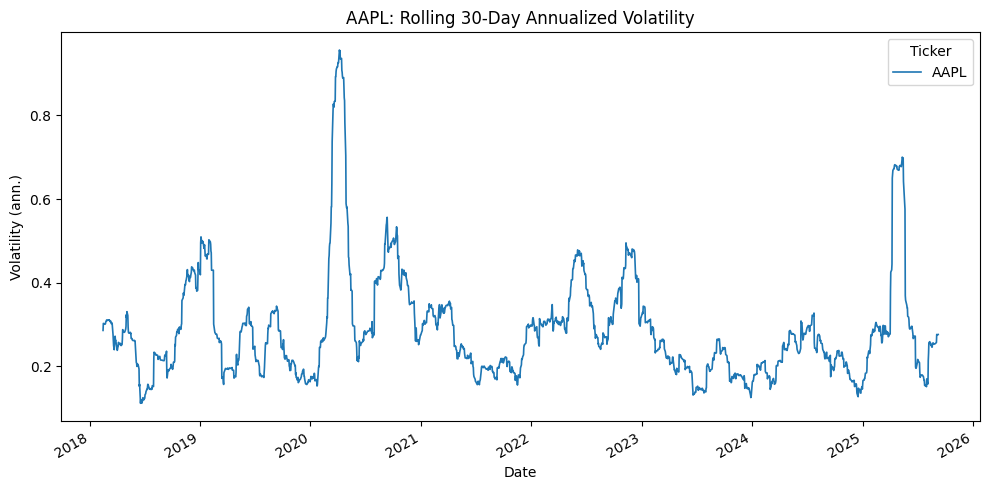

In [7]:
import matplotlib.pyplot as plt

# Make sure SELECTED_TICKER is defined
SELECTED_TICKER = "AAPL"  # or any ticker from prices_df.columns

# Daily returns (already defined from previous cell)
returns = prices_df.pct_change().dropna()

# Rolling volatility (30-day window)
roll_window = 30
rolling_vol = returns[SELECTED_TICKER].rolling(roll_window).std() * (252 ** 0.5)

plt.figure(figsize=(10, 5))
rolling_vol.plot(ax=plt.gca(), linewidth=1.2)
plt.title(f"{SELECTED_TICKER}: Rolling {roll_window}-Day Annualized Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility (ann.)")
plt.tight_layout()
plt.savefig(f"../output/figures/{SELECTED_TICKER}_rolling_vol.png", dpi=150)
plt.show()



## Correlation Matrix (Daily Returns)
A quick view of how similarly the tickers move.


In [8]:

corr = returns.corr()
corr.to_csv("../output/tables/correlation_matrix.csv")
corr


,Price,AAPL,MSFT
,Ticker,AAPL,MSFT
Price,Ticker,,
AAPL,AAPL,1.0000,0.7091
MSFT,MSFT,0.7091,1.0000


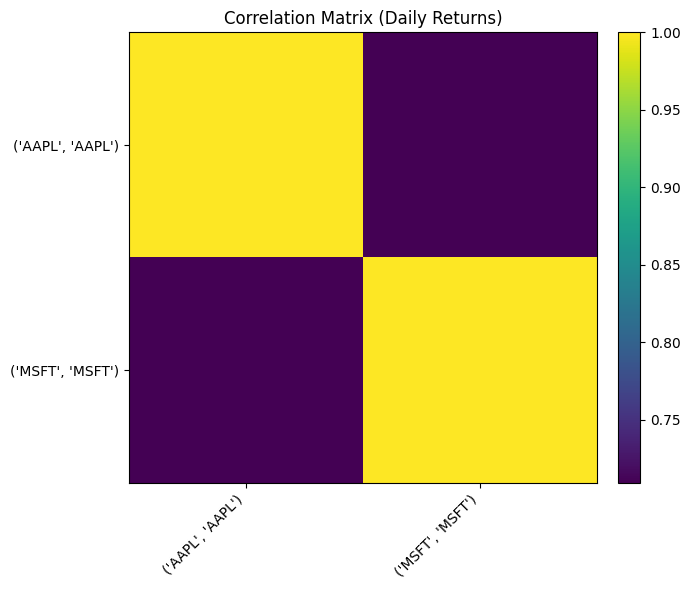

In [9]:

# Heatmap using matplotlib (no seaborn)
plt.figure(figsize=(7, 6))
im = plt.imshow(corr.values, aspect="auto")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Matrix (Daily Returns)")
plt.tight_layout()
plt.savefig("../output/figures/correlation_heatmap.png", dpi=150)
plt.show()



## Save & Export
All charts are saved to `../output/figures/` and tables to `../output/tables/`.  
Add a few of these charts to your README or CV for a clean presentation.



### Notes
- `yfinance` uses Yahoo Finance; tickers and coverage can vary.
- For **London Stock Exchange** tickers, append `.L` (e.g., `HSBA.L`, `BP.L`).
- If downloads fail/rate-limit, re-run the cell or reduce the ticker list.
